In [4]:
import os
import shutil
import random
from tqdm import tqdm

import numpy as np

import torch
import torchvision

import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
import torch.nn.functional as F
import torch.quantization

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

## Defining the model

In [6]:
class Net(nn.Module):
    def __init__(self, num_classes=4):
        super(Net, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 96, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),                 
            nn.Conv2d(96, 256, kernel_size=5, padding=2),         
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),               
            nn.Conv2d(256, 384, kernel_size=3, padding=1),        
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),       
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),        
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),               
        )
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),                        
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),                                
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),                     
        )

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

In [4]:
SEED = 42
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
random.seed(SEED)
np.random.seed(SEED)

generator = torch.Generator().manual_seed(SEED)

In [5]:
def validator_classwise(testloader=None, net=None, classes=None, beta=2):
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images = images.to(device)
            labels = labels.to(device)
            outputs = net(images)
            _, predictions = torch.max(outputs, 1)

            all_preds.extend(predictions.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    f2_scores = {}
    
    for i, classname in enumerate(classes):
        precision = precision_score(all_labels, all_preds, labels=[i], average='macro', zero_division=0)
        recall = recall_score(all_labels, all_preds, labels=[i], average='macro', zero_division=0)

        if precision + recall > 0:
            f2_score = (1 + beta**2) * (precision * recall) / ((beta**2 * precision) + recall)
        else:
            f2_score = 0

        f2_scores[classname] = f2_score
        print(f'F{beta}-Score for class: {classname} is {f2_score:.4f}')

    overall_f2_score = sum(f2_scores.values()) / len(classes)
    print(f'Overall F{beta}-Score: {overall_f2_score:.4f}')

    return f2_scores, overall_f2_score

In [6]:
def imshow(img, title):
    img = img / 2 + 0.5
    np_img = img.numpy()
    plt.imshow(np.transpose(np_img, (1, 2, 0)), cmap='gray')
    plt.title(title)
    plt.axis('off')

def show_predictions(model, dataloader, num_images=16):
    model.eval()
    images_shown = 0
    fig = plt.figure(figsize=(10, 10))
    
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            
            for i in range(len(images)):
                if images_shown >= num_images:
                    break
                
                ax = fig.add_subplot(4, 4, images_shown + 1)  # 4x4 grid
                imshow(images[i].cpu(), title=f'T: {labels[i].item()} | P: {preds[i].item()}')
                images_shown += 1
            
            if images_shown >= num_images:
                break

    plt.tight_layout()
    plt.show()

In [7]:
dataset_path = "Data"
training_dir = os.path.join(dataset_path, "Training")
train_dir = os.path.join(dataset_path, "Train")
val_dir = os.path.join(dataset_path, "Validation")

test_dir = os.path.join(dataset_path, 'Testing')

# # Create train and validation directories if they don't exist
# os.makedirs(train_dir, exist_ok=True)
# os.makedirs(val_dir, exist_ok=True)

# # Iterate over each class folder inside "Data/Training"
# for class_name in os.listdir(training_dir):
#     class_path = os.path.join(training_dir, class_name)

#     if os.path.isdir(class_path):
#         # Create corresponding class directories in Train and Validation
#         train_class_dir = os.path.join(train_dir, class_name)
#         val_class_dir = os.path.join(val_dir, class_name)
#         os.makedirs(train_class_dir, exist_ok=True)
#         os.makedirs(val_class_dir, exist_ok=True)
        
#         # Get all image files inside the class folder
#         image_files = [f for f in os.listdir(class_path) if os.path.isfile(os.path.join(class_path, f))]
        
#         # Split into training (90%) and validation (10%)
#         train_files, val_files = train_test_split(image_files, test_size=0.1, random_state=42)
        
#         # Move files to respective directories
#         for file_name in train_files:
#             shutil.move(os.path.join(class_path, file_name), os.path.join(train_class_dir, file_name))
#         for file_name in val_files:
#             shutil.move(os.path.join(class_path, file_name), os.path.join(val_class_dir, file_name))

# print("Dataset successfully split into Train and Validation directories.")

In [8]:
train_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((227, 227)),
    transforms.RandomRotation(10),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((227, 227)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

classes = ('Glioma', 'Meningioma', 'No Tumour', 'Pituitary')

In [9]:
train_dataset = torchvision.datasets.ImageFolder(root=train_dir, transform=train_transform)
test_dataset = torchvision.datasets.ImageFolder(root=test_dir, transform=transform)
val_dataset = torchvision.datasets.ImageFolder(root=val_dir, transform=transform)

BATCH_SIZE = 32
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, generator=generator)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True, generator=generator)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True, generator=generator)

In [10]:
model = Net().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=3e-04)

In [11]:
num_epochs = 50
beta = 2 

train_losses = []
val_losses = []

train_f2_scores = []
val_f2_scores = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    all_preds = []
    all_labels = []

    train_loader_tqdm = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Training", leave=False)
    for images, labels in train_loader_tqdm:
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)

        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

        train_loader_tqdm.set_postfix(loss=loss.item())

    train_loss = running_loss / len(train_loader)
    precision = precision_score(all_labels, all_preds, average='macro', zero_division=0)
    recall = recall_score(all_labels, all_preds, average='macro', zero_division=0)
    
    if precision + recall > 0:
        t_f2_score = (1 + beta**2) * (precision * recall) / ((beta**2 * precision) + recall)
    else:
        t_f2_score = 0

    train_losses.append(train_loss)
    train_f2_scores.append(t_f2_score)

    model.eval()
    running_loss = 0.0
    all_preds = []
    all_labels = []

    val_loader_tqdm = tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Validation", leave=False)
    with torch.no_grad():
        for images, labels in val_loader_tqdm:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item()

            _, predicted = torch.max(outputs, 1)

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

            val_loader_tqdm.set_postfix(loss=loss.item())

    val_loss = running_loss / len(val_loader)
    precision = precision_score(all_labels, all_preds, average='macro', zero_division=0)
    recall = recall_score(all_labels, all_preds, average='macro', zero_division=0)

    if precision + recall > 0:
        f2_score = (1 + beta**2) * (precision * recall) / ((beta**2 * precision) + recall)
    else:
        f2_score = 0

    val_losses.append(val_loss)
    val_f2_scores.append(f2_score)

    print(f"Epoch [{epoch+1}/{num_epochs}], "
          f"Train Loss: {train_loss:.4f}, Train F2-score: {t_f2_score:.4f}, "
          f"Val Loss: {val_loss:.4f}, Val F2-score: {f2_score:.4f}")
    print("----------------------------------------------------------------------------------")

Epoch [1/50], Train Loss: 0.9978, Train F2-score: 0.5482, Val Loss: 0.6522, Val F2-score: 0.7464
----------------------------------------------------------------------------------


Epoch [2/50], Train Loss: 0.7283, Train F2-score: 0.6992, Val Loss: 0.6465, Val F2-score: 0.7514
----------------------------------------------------------------------------------


Epoch [3/50], Train Loss: 0.6293, Train F2-score: 0.7398, Val Loss: 0.4468, Val F2-score: 0.8155
----------------------------------------------------------------------------------


Epoch [4/50], Train Loss: 0.5310, Train F2-score: 0.7858, Val Loss: 0.5731, Val F2-score: 0.7875
----------------------------------------------------------------------------------


Epoch [5/50], Train Loss: 0.4644, Train F2-score: 0.8157, Val Loss: 0.4268, Val F2-score: 0.8307
----------------------------------------------------------------------------------


Epoch [6/50], Train Loss: 0.4120, Train F2-score: 0.8389, Val Loss: 0.3115, Val F2-score: 0.8779
----------------------------------------------------------------------------------


Epoch [7/50], Train Loss: 0.3428, Train F2-score: 0.8635, Val Loss: 0.2432, Val F2-score: 0.9021
----------------------------------------------------------------------------------


Epoch [8/50], Train Loss: 0.3114, Train F2-score: 0.8780, Val Loss: 0.2604, Val F2-score: 0.9133
----------------------------------------------------------------------------------


Epoch [9/50], Train Loss: 0.2690, Train F2-score: 0.8965, Val Loss: 0.2401, Val F2-score: 0.9162
----------------------------------------------------------------------------------


Epoch [10/50], Train Loss: 0.2591, Train F2-score: 0.9024, Val Loss: 0.2167, Val F2-score: 0.9238
----------------------------------------------------------------------------------


Epoch [11/50], Train Loss: 0.2328, Train F2-score: 0.9149, Val Loss: 0.2018, Val F2-score: 0.9295
----------------------------------------------------------------------------------


Epoch [12/50], Train Loss: 0.1986, Train F2-score: 0.9241, Val Loss: 0.1367, Val F2-score: 0.9484
----------------------------------------------------------------------------------


Epoch [13/50], Train Loss: 0.1775, Train F2-score: 0.9341, Val Loss: 0.1966, Val F2-score: 0.9264
----------------------------------------------------------------------------------


Epoch [14/50], Train Loss: 0.1735, Train F2-score: 0.9320, Val Loss: 0.1346, Val F2-score: 0.9566
----------------------------------------------------------------------------------


Epoch [15/50], Train Loss: 0.1515, Train F2-score: 0.9466, Val Loss: 0.1923, Val F2-score: 0.9379
----------------------------------------------------------------------------------


Epoch [16/50], Train Loss: 0.1413, Train F2-score: 0.9481, Val Loss: 0.1311, Val F2-score: 0.9598
----------------------------------------------------------------------------------


Epoch [17/50], Train Loss: 0.1309, Train F2-score: 0.9494, Val Loss: 0.1012, Val F2-score: 0.9654
----------------------------------------------------------------------------------


Epoch [18/50], Train Loss: 0.1306, Train F2-score: 0.9522, Val Loss: 0.1421, Val F2-score: 0.9629
----------------------------------------------------------------------------------


Epoch [19/50], Train Loss: 0.1221, Train F2-score: 0.9572, Val Loss: 0.1557, Val F2-score: 0.9493
----------------------------------------------------------------------------------


Epoch [20/50], Train Loss: 0.1078, Train F2-score: 0.9582, Val Loss: 0.1671, Val F2-score: 0.9523
----------------------------------------------------------------------------------


Epoch [21/50], Train Loss: 0.1090, Train F2-score: 0.9607, Val Loss: 0.1215, Val F2-score: 0.9640
----------------------------------------------------------------------------------


Epoch [22/50], Train Loss: 0.1186, Train F2-score: 0.9602, Val Loss: 0.1086, Val F2-score: 0.9658
----------------------------------------------------------------------------------


Epoch [23/50], Train Loss: 0.0972, Train F2-score: 0.9644, Val Loss: 0.1130, Val F2-score: 0.9666
----------------------------------------------------------------------------------


Epoch [24/50], Train Loss: 0.0894, Train F2-score: 0.9675, Val Loss: 0.1072, Val F2-score: 0.9734
----------------------------------------------------------------------------------


Epoch [25/50], Train Loss: 0.1031, Train F2-score: 0.9624, Val Loss: 0.1196, Val F2-score: 0.9627
----------------------------------------------------------------------------------


Epoch [26/50], Train Loss: 0.0962, Train F2-score: 0.9652, Val Loss: 0.1160, Val F2-score: 0.9698
----------------------------------------------------------------------------------


Epoch [27/50], Train Loss: 0.0699, Train F2-score: 0.9735, Val Loss: 0.1093, Val F2-score: 0.9707
----------------------------------------------------------------------------------


Epoch [28/50], Train Loss: 0.0785, Train F2-score: 0.9697, Val Loss: 0.2294, Val F2-score: 0.9509
----------------------------------------------------------------------------------


Epoch [29/50], Train Loss: 0.0835, Train F2-score: 0.9688, Val Loss: 0.1021, Val F2-score: 0.9638
----------------------------------------------------------------------------------


Epoch [30/50], Train Loss: 0.0756, Train F2-score: 0.9764, Val Loss: 0.1201, Val F2-score: 0.9783
----------------------------------------------------------------------------------


Epoch [31/50], Train Loss: 0.0603, Train F2-score: 0.9786, Val Loss: 0.1389, Val F2-score: 0.9627
----------------------------------------------------------------------------------


Epoch [32/50], Train Loss: 0.0580, Train F2-score: 0.9796, Val Loss: 0.0995, Val F2-score: 0.9765
----------------------------------------------------------------------------------


Epoch [33/50], Train Loss: 0.0572, Train F2-score: 0.9819, Val Loss: 0.1602, Val F2-score: 0.9603
----------------------------------------------------------------------------------


Epoch [34/50], Train Loss: 0.0595, Train F2-score: 0.9786, Val Loss: 0.2362, Val F2-score: 0.9312
----------------------------------------------------------------------------------


Epoch [35/50], Train Loss: 0.0798, Train F2-score: 0.9723, Val Loss: 0.1326, Val F2-score: 0.9587
----------------------------------------------------------------------------------


Epoch [36/50], Train Loss: 0.0586, Train F2-score: 0.9802, Val Loss: 0.1281, Val F2-score: 0.9749
----------------------------------------------------------------------------------


Epoch [37/50], Train Loss: 0.0690, Train F2-score: 0.9789, Val Loss: 0.1330, Val F2-score: 0.9713
----------------------------------------------------------------------------------


Epoch [38/50], Train Loss: 0.0526, Train F2-score: 0.9805, Val Loss: 0.1195, Val F2-score: 0.9729
----------------------------------------------------------------------------------


Epoch [39/50], Train Loss: 0.0617, Train F2-score: 0.9795, Val Loss: 0.1421, Val F2-score: 0.9631
----------------------------------------------------------------------------------


Epoch [40/50], Train Loss: 0.0541, Train F2-score: 0.9828, Val Loss: 0.0944, Val F2-score: 0.9726
----------------------------------------------------------------------------------


Epoch [41/50], Train Loss: 0.0520, Train F2-score: 0.9794, Val Loss: 0.1300, Val F2-score: 0.9648
----------------------------------------------------------------------------------


Epoch [42/50], Train Loss: 0.0410, Train F2-score: 0.9854, Val Loss: 0.1074, Val F2-score: 0.9723
----------------------------------------------------------------------------------


Epoch [43/50], Train Loss: 0.0528, Train F2-score: 0.9829, Val Loss: 0.1201, Val F2-score: 0.9663
----------------------------------------------------------------------------------


Epoch [44/50], Train Loss: 0.0471, Train F2-score: 0.9837, Val Loss: 0.0937, Val F2-score: 0.9819
----------------------------------------------------------------------------------


Epoch [45/50], Train Loss: 0.0556, Train F2-score: 0.9816, Val Loss: 0.1265, Val F2-score: 0.9804
----------------------------------------------------------------------------------


Epoch [46/50], Train Loss: 0.0506, Train F2-score: 0.9842, Val Loss: 0.1781, Val F2-score: 0.9561
----------------------------------------------------------------------------------


Epoch [47/50], Train Loss: 0.0670, Train F2-score: 0.9787, Val Loss: 0.1354, Val F2-score: 0.9764
----------------------------------------------------------------------------------


Epoch [48/50], Train Loss: 0.0523, Train F2-score: 0.9825, Val Loss: 0.1180, Val F2-score: 0.9693
----------------------------------------------------------------------------------


Epoch [49/50], Train Loss: 0.0369, Train F2-score: 0.9877, Val Loss: 0.0957, Val F2-score: 0.9768
----------------------------------------------------------------------------------


Epoch [50/50], Train Loss: 0.0350, Train F2-score: 0.9879, Val Loss: 0.1980, Val F2-score: 0.9746
----------------------------------------------------------------------------------


In [12]:
model.eval()
running_loss = 0.0
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)
        running_loss += loss.item()

        _, predicted = torch.max(outputs, 1)

        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

test_loss = running_loss / len(test_loader)

precision = precision_score(all_labels, all_preds, average='macro', zero_division=0)
recall = recall_score(all_labels, all_preds, average='macro', zero_division=0)

beta = 2
if precision + recall > 0:
    f2_score = (1 + beta**2) * (precision * recall) / ((beta**2 * precision) + recall)
else:
    f2_score = 0

print(f"Final Test Loss: {test_loss:.4f}, Test F{beta}-Score: {f2_score:.4f}")

Final Test Loss: 0.1724, Test F2-Score: 0.9745


In [13]:
f2 = validator_classwise(testloader=test_loader, net=model, classes=classes)

F2-Score for class: Glioma is 0.9705
F2-Score for class: Meningioma is 0.9426
F2-Score for class: No Tumour is 0.9907
F2-Score for class: Pituitary is 0.9934
Overall F2-Score: 0.9743


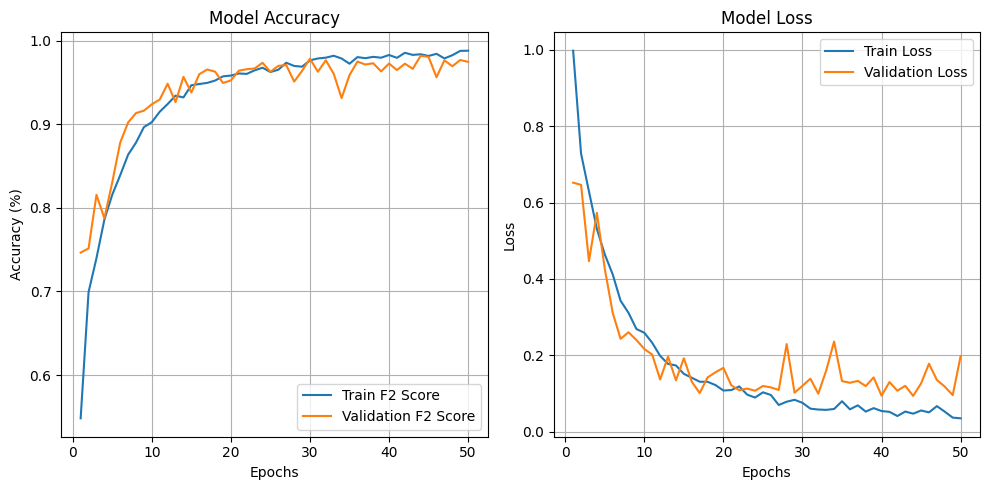

In [14]:
# Plot training and testing accuracy
plt.figure(figsize=(10, 5))

# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_f2_scores, label='Train F2 Score')
plt.plot(range(1, num_epochs + 1), val_f2_scores, label='Validation F2 Score')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Model Accuracy')
plt.legend()
plt.grid()

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()

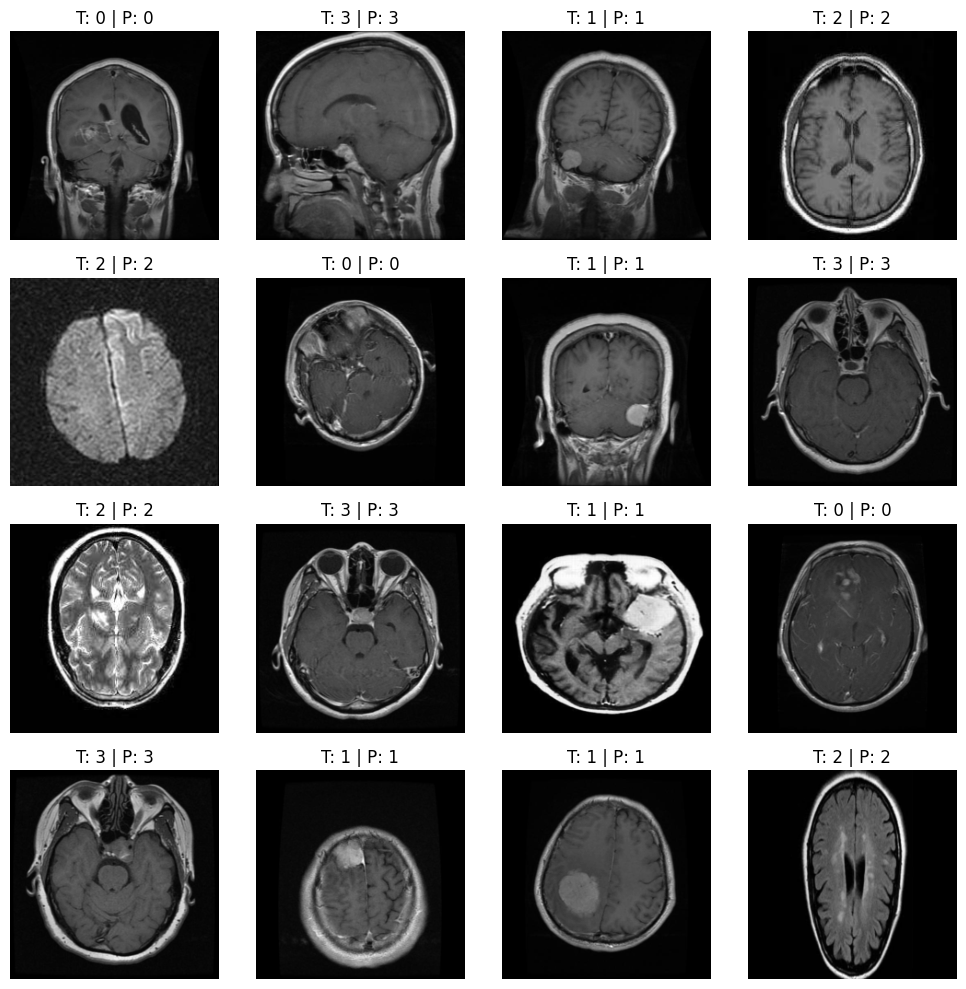

In [15]:
show_predictions(model, test_loader)

In [11]:
model.eval()
model_quantized = torch.quantization.quantize_dynamic(model, {torch.nn.Linear}, dtype=torch.qint8)
torch.save(model_quantized.state_dict(), "model_quantized.pth")